# 7. Neuronales Netz für Regression

**KI1-Projekt 308** — California Housing Datensatz

**Schwerpunkt P5 (Kernaufgabe):** Neuronales Netz mit TensorFlow/Keras
für die Vorhersage von Hauspreisen. Vergleich mit linearer Regression.

Vorlage: Blatt 12 (TensorFlow Regression), Kapitel 8 Folien

> ⚠️ **Python-Version:** Dieses Notebook benötigt **Python 3.13**.  
> TensorFlow (≥ 2.18) ist **nicht** kompatibel mit Python 3.14+.  
> Venv erstellen mit: `python3.13 -m venv .venv`

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.linear_model import LinearRegression

from utils.data import load_and_clean_data, get_train_test_split
from utils.evaluation import evaluate_predictions, add_result
from utils.plotting import plot_predicted_vs_actual, plot_residuals, save_fig

plt.rcParams['figure.dpi'] = 100
%matplotlib inline

print(f"TensorFlow Version: {tf.__version__}")

2026-02-20 07:16:01.318251: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-20 07:16:01.318471: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 07:16:01.350066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-20 07:16:02.176077: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

TensorFlow Version: 2.20.0


## 7.1 Daten laden (skaliert)

Neuronale Netze benötigen skalierte Eingabedaten für effizientes Training.

In [2]:
df = load_and_clean_data()
X_train, X_test, y_train, y_test, scaler, feature_names = get_train_test_split(df, scaler='standard')

# Validierungssplit aus Trainingsdaten
val_split = int(0.8 * len(X_train))
X_val, y_val = X_train[val_split:], y_train[val_split:]
X_train_nn, y_train_nn = X_train[:val_split], y_train[:val_split]

print(f"Training:   {X_train_nn.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test.shape}")
print(f"Features:   {feature_names}")

Training:   (11126, 8)
Validation: (2782, 8)
Test:       (3478, 8)
Features:   ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## 7.2 Referenz: Lineare Regression

Aufgabenstellung fordert explizit den Vergleich mit linearer Regression.

In [3]:
lr = LinearRegression()
lr.fit(X_train, y_train)

result_lr = evaluate_predictions(
    y_train, lr.predict(X_train),
    y_test, lr.predict(X_test),
    "Lineare Regression (Referenz)"
)
add_result(result_lr)


  Lineare Regression (Referenz)
  R² Score:  Train = 0.6465  |  Test = 0.6326
  MAE:       Train = 0.4252  |  Test = 0.4341
  RMSE:      Train = 0.5710  |  Test = 0.5779


## 7.3 Modell 1: Einfaches NN (1 Hidden Layer)

Zunächst ein minimales Netz als Ausgangspunkt.

In [4]:
def build_model(hidden_layers, activation='relu', learning_rate=0.001):
    """Erstelle ein Sequential-Modell mit gegebener Architektur."""
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
    
    model.add(layers.Dense(1))  # Regression Output
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae'],
    )
    return model


def train_and_evaluate(model, name, epochs=100, batch_size=32, verbose=0):
    """Trainiere und evaluiere ein Keras-Modell."""
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
    )
    
    y_train_pred = model.predict(X_train, verbose=0).flatten()
    y_test_pred = model.predict(X_test, verbose=0).flatten()
    
    result = evaluate_predictions(y_train, y_train_pred, y_test, y_test_pred, name)
    add_result(result)
    
    return history, result

In [5]:
model_1 = build_model([32], activation='relu', learning_rate=0.001)
model_1.summary()

history_1, result_1 = train_and_evaluate(model_1, "NN [32] ReLU", epochs=100)

E0000 00:00:1771568163.113897 1065870 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1771568163.119704 1065870 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)


  NN [32] ReLU
  R² Score:  Train = 0.7537  |  Test = 0.7400
  MAE:       Train = 0.3462  |  Test = 0.3538
  RMSE:      Train = 0.4767  |  Test = 0.4861


## 7.4 Modell 2: Tieferes Netz (3 Hidden Layers)

In [6]:
model_2 = build_model([64, 32, 16], activation='relu', learning_rate=0.001)
model_2.summary()

history_2, result_2 = train_and_evaluate(model_2, "NN [64,32,16] ReLU", epochs=200)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)


  NN [64,32,16] ReLU
  R² Score:  Train = 0.8379  |  Test = 0.7446
  MAE:       Train = 0.2690  |  Test = 0.3325
  RMSE:      Train = 0.3867  |  Test = 0.4817


## 7.5 Modell 3: Breiteres Netz

In [7]:
model_3 = build_model([128, 64, 32], activation='relu', learning_rate=0.001)
model_3.summary()

history_3, result_3 = train_and_evaluate(model_3, "NN [128,64,32] ReLU", epochs=200)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)


  NN [128,64,32] ReLU
  R² Score:  Train = 0.8806  |  Test = 0.7195
  MAE:       Train = 0.2251  |  Test = 0.3488
  RMSE:      Train = 0.3319  |  Test = 0.5049


## 7.6 Modell 4: Verschiedene Aktivierungsfunktionen

In [8]:
results_activation = {}

for act in ['relu', 'elu', 'tanh', 'sigmoid']:
    model = build_model([64, 32, 16], activation=act, learning_rate=0.001)
    history, result = train_and_evaluate(model, f"NN [64,32,16] {act}", epochs=200)
    results_activation[act] = result


  NN [64,32,16] relu
  R² Score:  Train = 0.8346  |  Test = 0.7410
  MAE:       Train = 0.2771  |  Test = 0.3400
  RMSE:      Train = 0.3906  |  Test = 0.4851

  NN [64,32,16] elu
  R² Score:  Train = 0.8171  |  Test = 0.7707
  MAE:       Train = 0.2856  |  Test = 0.3134
  RMSE:      Train = 0.4107  |  Test = 0.4565

  NN [64,32,16] tanh
  R² Score:  Train = 0.8433  |  Test = 0.7470
  MAE:       Train = 0.2673  |  Test = 0.3260
  RMSE:      Train = 0.3802  |  Test = 0.4795

  NN [64,32,16] sigmoid
  R² Score:  Train = 0.7814  |  Test = 0.7636
  MAE:       Train = 0.3159  |  Test = 0.3250
  RMSE:      Train = 0.4490  |  Test = 0.4635


## 7.7 Modell 5: Tiefes Netz mit Regularisierung

In [9]:
model_5 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1),
])

model_5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae'],
)

model_5.summary()
history_5, result_5 = train_and_evaluate(model_5, "NN [128,64,32,16] + Dropout", epochs=300)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)


  NN [128,64,32,16] + Dropout
  R² Score:  Train = 0.8347  |  Test = 0.7661
  MAE:       Train = 0.2726  |  Test = 0.3096
  RMSE:      Train = 0.3905  |  Test = 0.4610


## 7.8 Lernkurven visualisieren

Gespeichert: results/nn_learning_curves.png und results/nn_learning_curves.pdf


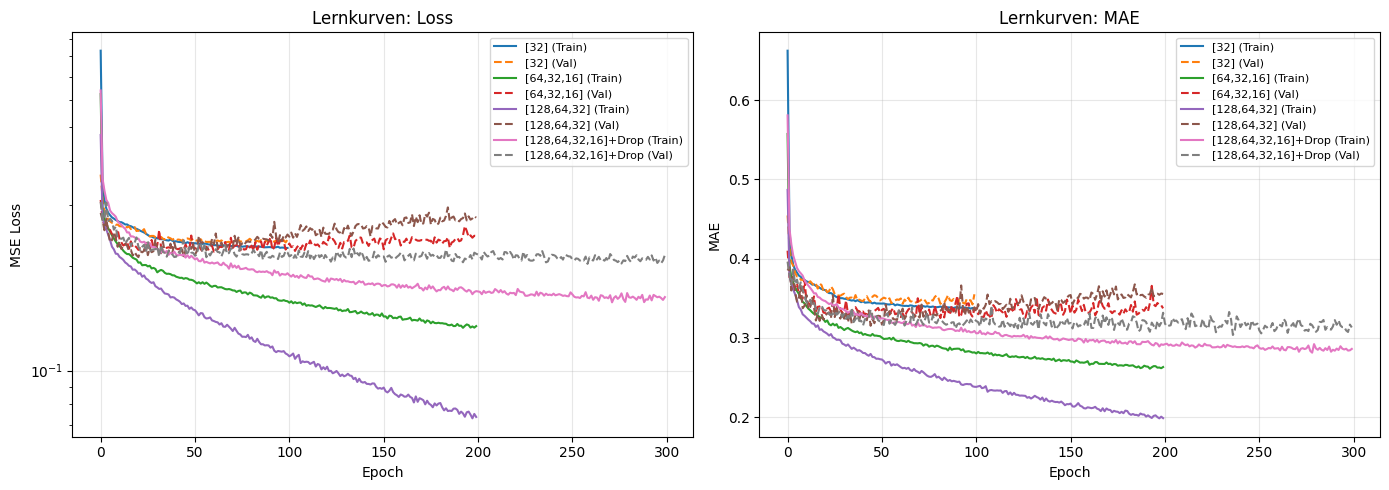

In [10]:
def plot_training_history(histories, names):
    """Lernkurven mehrerer Modelle."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for hist, name in zip(histories, names):
        axes[0].plot(hist.history['loss'], label=f'{name} (Train)')
        axes[0].plot(hist.history['val_loss'], '--', label=f'{name} (Val)')
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].set_title('Lernkurven: Loss')
    axes[0].legend(fontsize=8)
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)
    
    for hist, name in zip(histories, names):
        axes[1].plot(hist.history['mae'], label=f'{name} (Train)')
        axes[1].plot(hist.history['val_mae'], '--', label=f'{name} (Val)')
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Lernkurven: MAE')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    fig.tight_layout()
    save_fig(fig, 'nn_learning_curves')
    return fig

fig = plot_training_history(
    [history_1, history_2, history_3, history_5],
    ['[32]', '[64,32,16]', '[128,64,32]', '[128,64,32,16]+Drop']
)
plt.show()

## 7.9 Vergleich NN vs. Lineare Regression

Gespeichert: results/nn_vs_linear_regression.png und results/nn_vs_linear_regression.pdf


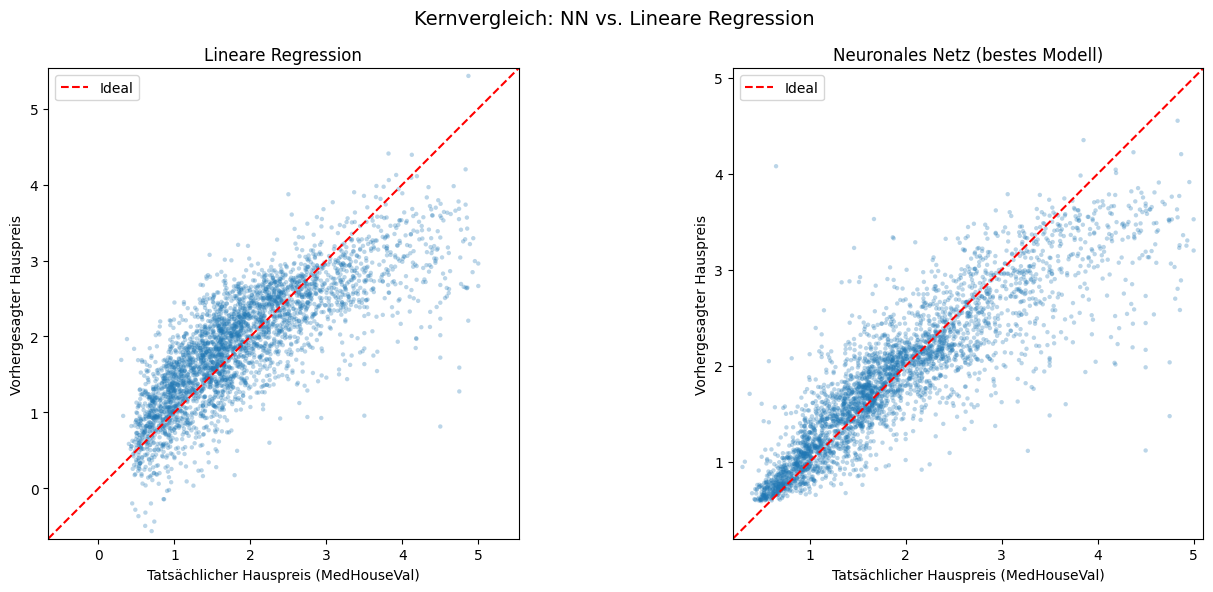

In [11]:
# Bestes NN-Modell vs. Lineare Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_predicted_vs_actual(
    y_test, lr.predict(X_test),
    title="Lineare Regression", ax=axes[0]
)

# Das beste NN-Modell (manuell auswählen nach Ergebnissen)
best_nn = model_5  # Anpassen je nach Ergebnis
y_pred_nn = best_nn.predict(X_test, verbose=0).flatten()
plot_predicted_vs_actual(
    y_test, y_pred_nn,
    title="Neuronales Netz (bestes Modell)", ax=axes[1]
)

fig.suptitle("Kernvergleich: NN vs. Lineare Regression", fontsize=14)
fig.tight_layout()
save_fig(fig, 'nn_vs_linear_regression')
plt.show()

## 7.10 Zusammenfassung

| Aspekt | Lineare Regression | Neuronales Netz |
|--------|-------------------|-----------------|
| R² Test | _eintragen_ | _eintragen_ |
| MAE Test | _eintragen_ | _eintragen_ |
| Trainingszeit | < 1s | _eintragen_ |
| Interpretierbarkeit | Hoch (Koeffizienten) | Gering (Black Box) |
| Hyperparameter | Keine | Architektur, LR, Epochs, ... |

**Fazit:**
- _Hier Ergebnisse und Interpretation eintragen_
- _Wann lohnt sich ein NN gegenüber linearer Regression?_
- _Grenzen und offene Fragen_